# Goals: The goal is to build a model that can predict the main programming language of a repository, given the text of the README file.

# ACQUIRE

In [1]:
# import
import requests
import json
from bs4 import BeautifulSoup

In [2]:
# set up API request headers
from env import github_token, github_username

headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

In [3]:
# make API requests to get repository names
language = "python"
api_url = f"https://api.github.com/search/repositories?q=language:{language}&sort=stars&order=desc&per_page=100"
response = requests.get(api_url, headers=headers)

if response.status_code == 200:
    repositories = response.json()["items"]
else:
    print(f"Failed to fetch repository list. Status code: {response.status_code}")
    exit()

Goal: add all these results to a list, then find a way to go through and request another 10 results with always adding them to a list. clean up emphasis text from entries

In [4]:
import requests
import json
from env import github_token, github_username

# Define the headers with your token and username
headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}

# Define a function to get repositories based on a query and page
def get_repositories(query, sort="stars", order="desc", page=1):
    base_url = "https://api.github.com/search/repositories"
    params = {
        "q": query,
        "sort": sort,
        "order": order,
        "per_page": 10,  # You can get up to 100 results per page.
        "page": page  # Specify the page number
    }
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Search for breast cancer related repositories and handle pagination
query = "breast cancer"
page = 1

# Create a list to collect the repository data
repository_data = []

while page <= 10:
    response_json = get_repositories(query, page=page)
    if response_json is None:
        print(f"Failed to fetch page {page} of repositories.")
        break

    # Extract and collect repository names
    for repo in response_json["items"]:
        repository_data.append({
            "full_name": repo["full_name"]
        })

    # Check if there are more pages
    if "Link" in response.headers:
        next_link = response.headers["Link"]
        if 'rel="next"' not in next_link:
            break
    else:
        break
    page += 1


In [5]:
# ... (Previous code remains the same)

# Extract only the repository names from the dictionaries
repository_names = [repo_data["full_name"] for repo_data in repository_data]

# Save the repository names list to a JSON file
with open("breast_cancer_repository.json", "w") as json_file:
    json.dump(repository_names, json_file, indent=2)

print("Data saved to breast_cancer_repository.json")


Data saved to breast_cancer_repository.json


In [6]:
import pandas as pd
df = pd.read_json('github_data.json')
df.shape

(200, 3)

In [7]:
df

,repo,language,readme_contents
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...
...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...
197,/srihari2761/breast_cancer,Jupyter Notebook,# breast_cancer\nBreast cancer detection using...
198,/lthhieu/breast-cancer,Jupyter Notebook,# breast-cancer\nonly 6.5 ...\n


# Prep phase

* removed all \n with spaces, urls, unicode characters, special characters, 
* tokenized and lemmatize
* Feature engineer a column name others to store languages otherthan top 3

In [8]:
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [9]:
import wrangle as w

In [10]:
df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)

# tokenizes, cleans, remove stopwprds, lemmatize the text in the readme_contents and 
# stores the processed text in a new column clean_norm_token
# extra steps were taken to 
df.clean_norm_token = df.clean_norm_token.str.replace('124', '')
df
# it removes any occurences of the string '124' from the clean_norm_token column

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...,improved prediction outcome identifying hetero...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...,mvfcascnn tensorflow implementation pricai18 p...
197,/srihari2761/breast_cancer,Jupyter Notebook,# breast_cancer\nBreast cancer detection using...,breastcancer detection using cnn transfer lear...
198,/lthhieu/breast-cancer,Jupyter Notebook,# breast-cancer\nonly 6.5 ...\n,breastcancer 65


In [11]:
df.language.value_counts()

Python              85
Jupyter Notebook    78
R                   11
HTML                 4
Matlab               4
C#                   3
MATLAB               3
TeX                  2
Dart                 2
Objective-C          1
Lua                  1
Java                 1
Name: language, dtype: int64

In [12]:
# List of languages to combine into "Other"
languages_to_combine = ['Jupyter Notebook', 'MATLAB','Matlab', 'TeX', 'C#', 'Matlab', 'Objective-C', 'Dart', 'Lua', 'Java']
# Replace the specified languages with "Other"
# by doing this we will have top 3 language used and 'other'
df['language'] = df['language'].replace(languages_to_combine, 'other')

In [13]:
df.language.value_counts()

other     95
Python    85
R         11
HTML       4
Name: language, dtype: int64

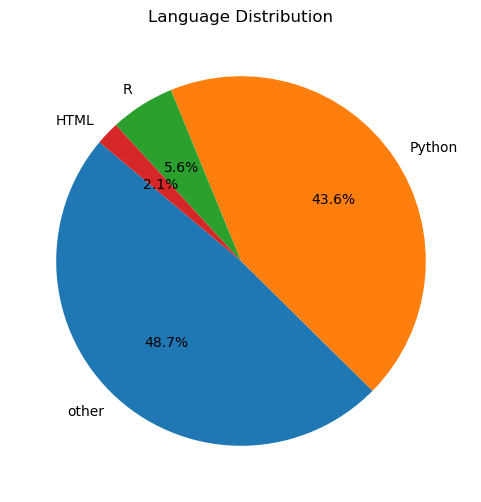

In [14]:
import matplotlib.pyplot as plt
# Assuming df is your DataFrame
# Get the value counts for the 'language' column
language_counts = df['language'].value_counts().head(4)
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution')
plt.show()

# Exploration

In [15]:
import re
import unicodedata
import pandas as pd
import nltk

In [16]:
word_counts = {}  # Define word_counts as an empty dictionary

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts[language] = len(words)

# Create a DataFrame from the word counts dictionary
word_counts_df = pd.DataFrame(word_counts.items(), columns=['language', 'word_count'])

# Display the word counts
print(word_counts_df)
transposed_df = word_counts_df.transpose()
print(transposed_df)

  language  word_count
0    other       21831
1   Python       22980
2        R        1882
3     None           0
4     HTML         476
                0       1     2     3     4
language    other  Python     R  None  HTML
word_count  21831   22980  1882     0   476


Python has the most word counts, but what is the most common word?

### Word cloud 

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    # Check if there are words to generate a word cloud from
    if len(words) > 0:
        # Convert the list of words into a single string
        words_text = ' '.join(words)
        # Create a word cloud for the language
        wordcloud = WordCloud(width=800, height=400).generate(words_text)
        # Plot the word cloud
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{language} Word Cloud')
        plt.axis('off')
        plt.show()
    else:
        print(f'No words to generate a word cloud for {language}')

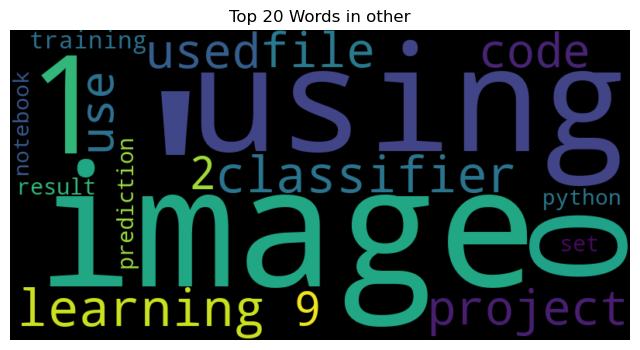

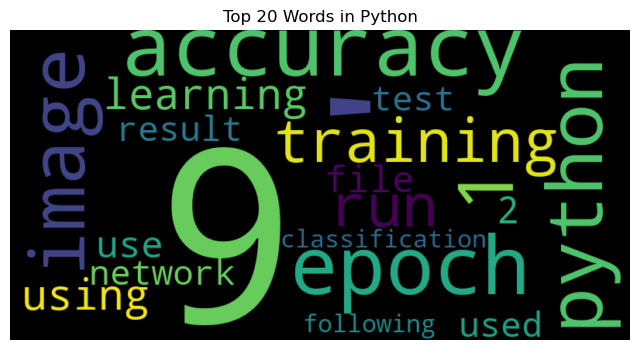

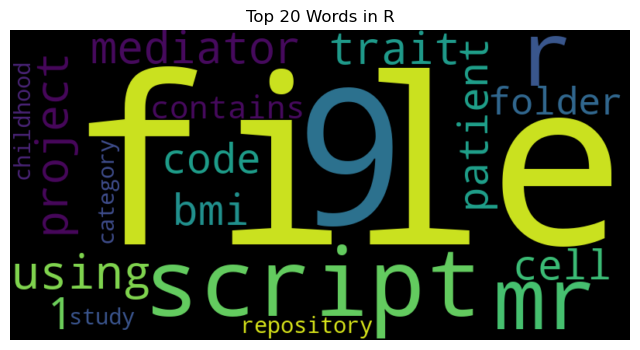

No top words to generate a word cloud for None


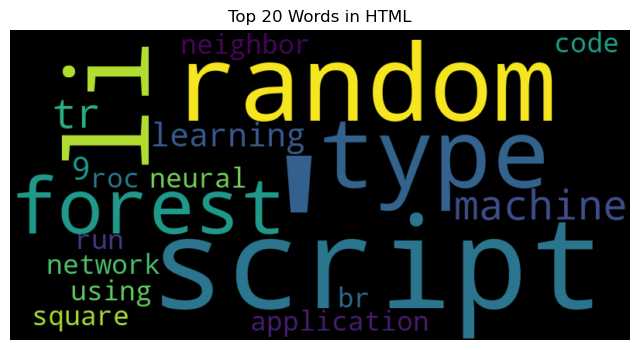

Proportion of Top 20 Words in other:
'             0.019605
image         0.007146
using         0.006230
1             0.005405
0             0.005222
learning      0.005085
classifier    0.004855
project       0.004764
used          0.004718
file          0.004718
9             0.004352
code          0.004306
use           0.004260
2             0.004077
training      0.004031
set           0.003619
result        0.003573
prediction    0.003527
python        0.003206
notebook      0.003115
dtype: float64

Proportion of Top 20 Words in Python:
9                 0.030374
'                 0.008616
accuracy          0.008268
epoch             0.007485
1                 0.006832
python            0.006789
image             0.006614
training          0.006484
run               0.006440
learning          0.005875
using             0.005875
2                 0.004700
file              0.004482
use               0.004395
used              0.003829
test              0.003786
result           

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary to store the top words for each language
top_words_by_language = {}

# Create a dictionary to store the total word counts for each language
total_word_counts_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts = pd.Series(words).value_counts()
    total_word_counts_by_language[language] = len(words)
    
    # Get the top 20 words for the language
    top_words = word_counts.head(20)
    
    # Store the top words in the dictionary
    top_words_by_language[language] = top_words

# Create a word cloud for the top 20 words in each language
for language, top_words in top_words_by_language.items():
    if len(top_words) > 0:
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_words)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Top 20 Words in {language}')
        plt.axis('off')
        plt.show()
    else:
        print(f'No top words to generate a word cloud for {language}')

# Calculate and display the proportion of the top 20 words for each language
for language, top_words in top_words_by_language.items():
    total_words = total_word_counts_by_language[language]
    proportion = top_words / total_words
    print(f'Proportion of Top 20 Words in {language}:\n{proportion}\n')


From this visualization I can see a few things 
* the word 'accuracy', and 'epoch' have a relationship with Python
* the word script have a relationship with HTML
* the word 'file' a relationship with R
* the word 'image' a relationship with other languages

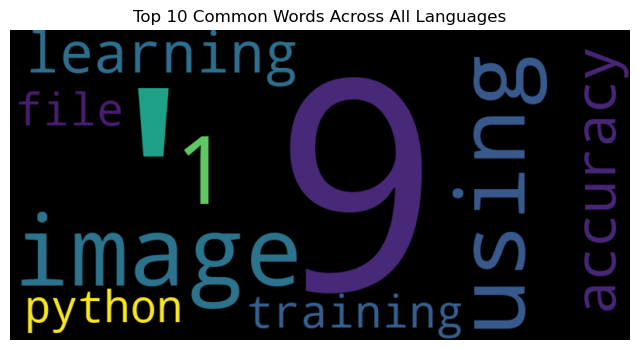

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary to store the word frequencies across all languages
all_languages_word_counts = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts = pd.Series(words).value_counts()
    
    # Aggregate the word counts across all languages
    for word, count in word_counts.items():
        if word in all_languages_word_counts:
            all_languages_word_counts[word] += count
        else:
            all_languages_word_counts[word] = count

# Get the top 10 words across all languages
top_10_words = pd.Series(all_languages_word_counts).sort_values(ascending=False).head(10)

# Create a word cloud for the top 10 words
if len(top_10_words) > 0:
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_10_words)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Top 10 Common Words Across All Languages')
    plt.axis('off')
    plt.show()
else:
    print('No top words to generate a word cloud for all languages')


# Bigram

NameError: name 'top_bigrams_by_language' is not defined

## Explore Takeaways:



# Hypothesis 1



# Hypothesis 2 


# Hypothesis 3


# Hypothesis 4


# Stat test

# Modeling 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# looking at the clean_norm_token column

In [50]:
# looking at the clean_norm_token column
X = df.clean_norm_token
y = df.language

In [51]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=31)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Calculating baseline
baseline_acc = y_train.value_counts().max() / y_train.shape[0] * 100

print(f'Baseline accuracy for the training set: {round(baseline_acc, 2)}.')


Baseline accuracy for the training set: 48.53.


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [53]:
# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

### 5 models

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Logistic Regression
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_tfidf, y_train)
y_val_preds_lr = logistic_regression_model.predict(X_val_tfidf)

# Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_tfidf, y_train)
y_val_preds_dt = decision_tree_model.predict(X_val_tfidf)

# Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_tfidf, y_train)
y_val_preds_rf = random_forest_model.predict(X_val_tfidf)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
knn_model.fit(X_train_tfidf, y_train)
y_val_preds_knn = knn_model.predict(X_val_tfidf)

# Evaluate the models
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_val_preds_lr))

print("Decision Tree Classification Report:")
print(classification_report(y_val, y_val_preds_dt))

print("Random Forest Classification Report:")
print(classification_report(y_val, y_val_preds_rf))

print("K-Nearest Neighbors (KNN) Classification Report:")
print(classification_report(y_val, y_val_preds_knn))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Python       0.60      0.67      0.63         9
           R       0.00      0.00      0.00         5
       other       0.58      0.73      0.65        15

    accuracy                           0.59        29
   macro avg       0.39      0.47      0.43        29
weighted avg       0.49      0.59      0.53        29

Decision Tree Classification Report:
              precision    recall  f1-score   support

      Python       0.64      0.78      0.70         9
           R       0.00      0.00      0.00         5
       other       0.61      0.73      0.67        15

    accuracy                           0.62        29
   macro avg       0.42      0.50      0.46        29
weighted avg       0.51      0.62      0.56        29

Random Forest Classification Report:
              precision    recall  f1-score   support

      Python       0.50      0.44      0.47         9
           R

# What to do next? 

* to have more time to develop medical terminology libraries to rid of all medical term that pop up in the top 10 words
* if i were to cross examine the words in each columns with the combine word cloud, then i can rid of multiple words 